# Agent Observability with Langfuse


Unlike traditional deterministic software, agentic AI systems produce non-deterministic, multi-step, and multi-agent behaviors that shift the operational question from "is it up?" to "is it right?".
[(IBM, Agent Observability and Operations)](https://www.ibm.com/downloads/documents/us-en/1443d5dd174f42e6)


Making observability essential to capture rich telemetry, ensure traceability, and manage correctness, safety, and resilience in production.

This notebook demonstrates how to capture traces of AI agents using **Langfuse** for observability and tracing and how to read a trace.

1. **Langfuse Setup** - Installing and configuring Langfuse for tracing
2. **Agent Implementation** - Building a simple agent
3. **Instrumenting your Agent with Langfuse Tracing** - Capture a trace with callback handler.
4. **Collect and read a trace** - Collect and read a trace.
5. **Conclusion**
6. **Advanced topics** - Create a langfuse experiment - Capture a trace manually from langgraph events

## 1. Setup & Installation

While you can choose from several tools, this recipe is best suited for a Jupyter Notebook. Jupyter Notebooks are widely used within data science to combine code with various data sources such as text, images and data visualizations. 

You can run this notebook in [Colab](https://colab.research.google.com/drive/1kZl5o2oDJEQ72kLedaetQ7UXqFU9BEW2?usp=sharing), or download it to your system and [run the notebook locally](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started_with_Jupyter_Locally/Getting_Started_with_Jupyter_Locally.md). 

To avoid Python package dependency conflicts, we recommend setting up a [virtual environment](https://docs.python.org/3/library/venv.html).

Note, this notebook is compatible with Python 3.12 and well as Python 3.11, the default in Colab at the time of publishing this recipe. To check your python version, you can run the `!python --version` command in a code cell.

### Install relevant libraries and set up credentials and the Granite model

We'll need a few libraries for this recipe. We will be using LangGraph and LangChain libraries to use Granite on watsonx.ai.

In [ ]:
# Install required packages
!pip install -q langfuse langchain langgraph langchain_ibm pandas python-dotenv matplotlib seaborn rich rouge-score
!pip install -q "git+https://github.com/ibm-granite-community/utils.git"

### Import Dependencies

In [ ]:
import os
import uuid
import json
from typing import Optional
import requests
import seaborn as sns
from typing import Any
from ibm_granite_community.notebook_utils import get_env_var
from langchain_core.utils.utils import convert_to_secret_str
from langchain_core.messages import HumanMessage
from langchain.chat_models import init_chat_model
from langchain.agents import create_agent
from langgraph.graph.state import CompiledStateGraph
from langfuse import Langfuse
from langfuse import Evaluation
from langfuse.langchain import CallbackHandler
from langfuse import get_client
from langfuse.api.resources.commons.types.trace_with_full_details import TraceWithFullDetails
from rich import print
from rouge_score import rouge_scorer
from typing import Annotated, TypedDict
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
import urllib

### Setting up Langfuse

Langfuse gives you full visibility into your agent's behavior.

You can get started in two ways:

**Self-hosted** to run Langfuse locally using Docker Compose. Follow the [deployment guide](https://langfuse.com/self-hosting/deployment/docker-compose) to get up and running.

**Cloud** if you prefer a managed setup [create a free account](https://us.cloud.langfuse.com/).


#### Connecting to Langfuse

Once you have access, grab your API credentials:

1. Create a new project
2. Go to **Settings → API Keys** and generate a new key pair
3. Copy your **Public Key**, **Secret Key**, and **Host URL**

You are now ready to initialize the Langfuse client and start capturing agents traces.

#### Initialize Langfuse Client

In [ ]:
LANGFUSE_PUBLIC_KEY=convert_to_secret_str(get_env_var("LANGFUSE_PUBLIC_KEY", "unset"))
LANGFUSE_SECRET_KEY=convert_to_secret_str(get_env_var("LANGFUSE_SECRET_KEY", "unset"))
LANGFUSE_HOST=convert_to_secret_str(get_env_var("LANGFUSE_HOST", "unset"))

langfuse_client = Langfuse(
    public_key=os.environ['LANGFUSE_PUBLIC_KEY'],
    secret_key=os.environ['LANGFUSE_SECRET_KEY'],
    host=os.environ['LANGFUSE_HOST']
)

## 2. Agent Implementation

### Set up a watsonx.ai instance

See [Getting Started with IBM watsonx](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_WatsonX.ipynb) for information on getting ready to use watsonx.ai. 

You'll need the following environment variables for watsonx.ai:
- `WATSONX_URL`: Your watsonx.ai endpoint URL
- `WATSONX_APIKEY`: Your watsonx.ai API key
- `WATSONX_PROJECT_ID`: Your watsonx.ai project ID

Set these in a `.env` file or export them as environment variables.


In [ ]:
model = "ibm/granite-4-h-small"

model_parameters = {
    "temperature": 0,
    "max_completion_tokens": 200,
    "repetition_penalty": 1.05,
}

llm_granite = init_chat_model(
    model=model,
    model_provider="ibm",
    url=convert_to_secret_str(get_env_var("WATSONX_URL")),
    apikey=convert_to_secret_str(get_env_var("WATSONX_APIKEY")),
    project_id=get_env_var("WATSONX_PROJECT_ID"),
    params=model_parameters,
)

### Define the tools

We define two functions to be used as tools by our agent. These functions can use real web APIs if you obtain the necessary API keys. If you are unable to get the API keys, the tools below will respond with a fixed, predetermined value for demonstration purposes.

- **`get_stock_price`**: Uses an `AV_STOCK_API_KEY` from [Alpha Vantage](https://www.alphavantage.co/support/#api-key)
- **`get_current_weather`**: Uses a `WEATHER_API_KEY` from [OpenWeather](https://home.openweathermap.org/users/sign_up)

**Store these private keys in a separate `.env` file in the same level of your directory as this notebook.**

In [ ]:
AV_STOCK_API_KEY = convert_to_secret_str(get_env_var("AV_STOCK_API_KEY", "unset"))
WEATHER_API_KEY = convert_to_secret_str(get_env_var("WEATHER_API_KEY", "unset"))

The function's docstring and type information are important for generating proper tool information, as this will be the basis of the tool description provided to the model.

In [ ]:
def get_stock_price(ticker: str, date: str) -> dict:
    """
    Retrieves the lowest and highest stock prices for a given ticker and date.

    Args:
        ticker: The stock ticker symbol, for example, "IBM".
        date: The date in "YYYY-MM-DD" format for which you want to get stock prices.

    Returns:
        A dictionary containing the low and high stock prices on the given date.
    """
    print(f"Getting stock price for {ticker} on {date}")

    apikey = AV_STOCK_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return {
            "low": "245.4500",
            "high": "249.0300"
        }

    try:
        stock_url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={ticker}&apikey={apikey}"
        stock_data = requests.get(stock_url)
        data = stock_data.json()
        stock_low = data["Time Series (Daily)"][date]["3. low"]
        stock_high = data["Time Series (Daily)"][date]["2. high"]
        return {
            "low": stock_low,
            "high": stock_high
        }
    except Exception as e:
       print(f"Error fetching stock data: {e}")
       return {
           "low": "none",
           "high": "none"
       }


The `get_current_weather` function retrieves the real-time weather in a given location using the Current Weather Data API via [OpenWeather](https://openweathermap.org/api). 

In [ ]:
def get_current_weather(location: str) -> dict:
    """
    Fetches the current weather for a given location (default: San Francisco).

    Args:
        location: The name of the city for which to retrieve the weather information.

    Returns:
        A dictionary containing weather information such as temperature in celsius, weather description, and humidity.
    """
    print(f"Getting current weather for {location}")
    apikey=WEATHER_API_KEY.get_secret_value()
    if apikey == "unset":
        print("No API key present; using a fixed, predetermined value for demonstration purposes")
        return {
            "description": "thunderstorms",
            "temperature": 25.3,
            "humidity": 94
        }

    try:
        # API request to fetch weather data
        weather_url = f"https://api.openweathermap.org/data/2.5/weather?q={location}&appid={apikey}&units=metric"
        weather_data = requests.get(weather_url)
        data = weather_data.json()
        # Extracting relevant weather details
        weather_description = data["weather"][0]["description"]
        temperature = data["main"]["temp"]
        humidity = data["main"]["humidity"]

        # Returning weather details
        return {
            "description": weather_description,
            "temperature": temperature,
            "humidity": humidity
        }
    except Exception as e:
        print(f"Error fetching weather data: {e}")
        return {
            "description": "none",
            "temperature": "none",
            "humidity": "none"
        }


### Create the agent

LangChain provides a convenient method to create a function-calling agent. You just need to provide the model and the list of tools. For a detailed walkthrough of building agents from scratch with LangGraph, see the [Function Calling Agent recipe](../Function_Calling/Function_Calling_Agent.ipynb).

We use `create_agent` from LangChain to quickly build our function-calling agent. Not specifying the `prompt` argument means the agent will use the default system prompt for tool calling.

In [ ]:
# (Optional) Ensure prebuilt components are available for LangChain agents.
%pip install -q -U langgraph-prebuilt

In [ ]:
tools = [get_stock_price, get_current_weather]

agent: CompiledStateGraph = create_agent(
    model=llm_granite,
    tools=tools,
)

Let's verify the agent works with a simple query:

In [ ]:
class State(TypedDict, total=False):
    """Agent state that holds the conversation messages."""
    messages: Annotated[list[AnyMessage], add_messages]

def function_calling_agent(graph: CompiledStateGraph, user_input: str):
    """Helper function to run the agent and display the conversation."""
    user_message = HumanMessage(user_input)
    print(user_message.pretty_repr())
    input_state = State(messages=[user_message])
    for event in graph.stream(input_state):
        for value in event.values():
            print(value["messages"][-1].pretty_repr())

# Test the agent with a simple query
function_calling_agent(agent, "What is the weather in Miami?")

## 3. Instrumenting your Agent with Langfuse Tracing

### What is a trace ?

A Langfuse trace represents a single request or operation in your AI application.

It captures the entire lifecycle of an execution, from the initial input to the final output, along with all intermediate steps and metadata.

### Observations

Each trace contains multiple observations that log individual steps of execution.
Observations provide granular visibility into what happens during a request, enabling detailed debugging and performance optimization.

They automatically nest through OpenTelemetry context propagation - each new observation becomes a child of the currently active one.

### Observation Types

| Type | Purpose |
|------|---------|
| **event** | Discrete point-in-time occurrences |
| **span** | Operations with duration |
| **generation** | AI model calls (prompts, tokens, costs) |
| **agent** | LLM-guided application flow decisions |
| **tool** | External API/service calls |
| **chain** | Links between application steps |
| **retriever** | Data retrieval (vector stores, databases) |
| **evaluator** | Assessment of LLM output quality |
| **embedding** | Embedding generation with metrics |
| **guardrail** | Protection against malicious content |


### Tracing with Langfuse CallbackHandler

Pass the Langfuse CallbackHandler via the config parameter to automatically capture the full execution trace of the function calling agent LangGraph agent created earlier.

In [ ]:
langfuse_handler = CallbackHandler()

user_input = "What is the weather in Miami?"

config = {"callbacks": [langfuse_handler]}
input_state = State(messages=[user_input])
result = agent.invoke(input_state, config=config)

print(result.get('messages')[-1].content)

### Review Langfuse trace in Langfuse UI

The trace view shows the full execution tree of your LangGraph agent. 

Key things to note:

- granite-4 LLM calls are represented by ChatWatsonX nodes. Click into one to see the system prompt, user message,tools and response in the right-hand panel. The panel header shows the model name, token counts, and latency.
- When the model invokes a tool, it appears as a separate tools node in the trace.

Note: Tools are listed in Langfuse under role: tool but this is a UI representation only — they are not sent to the model in this format.

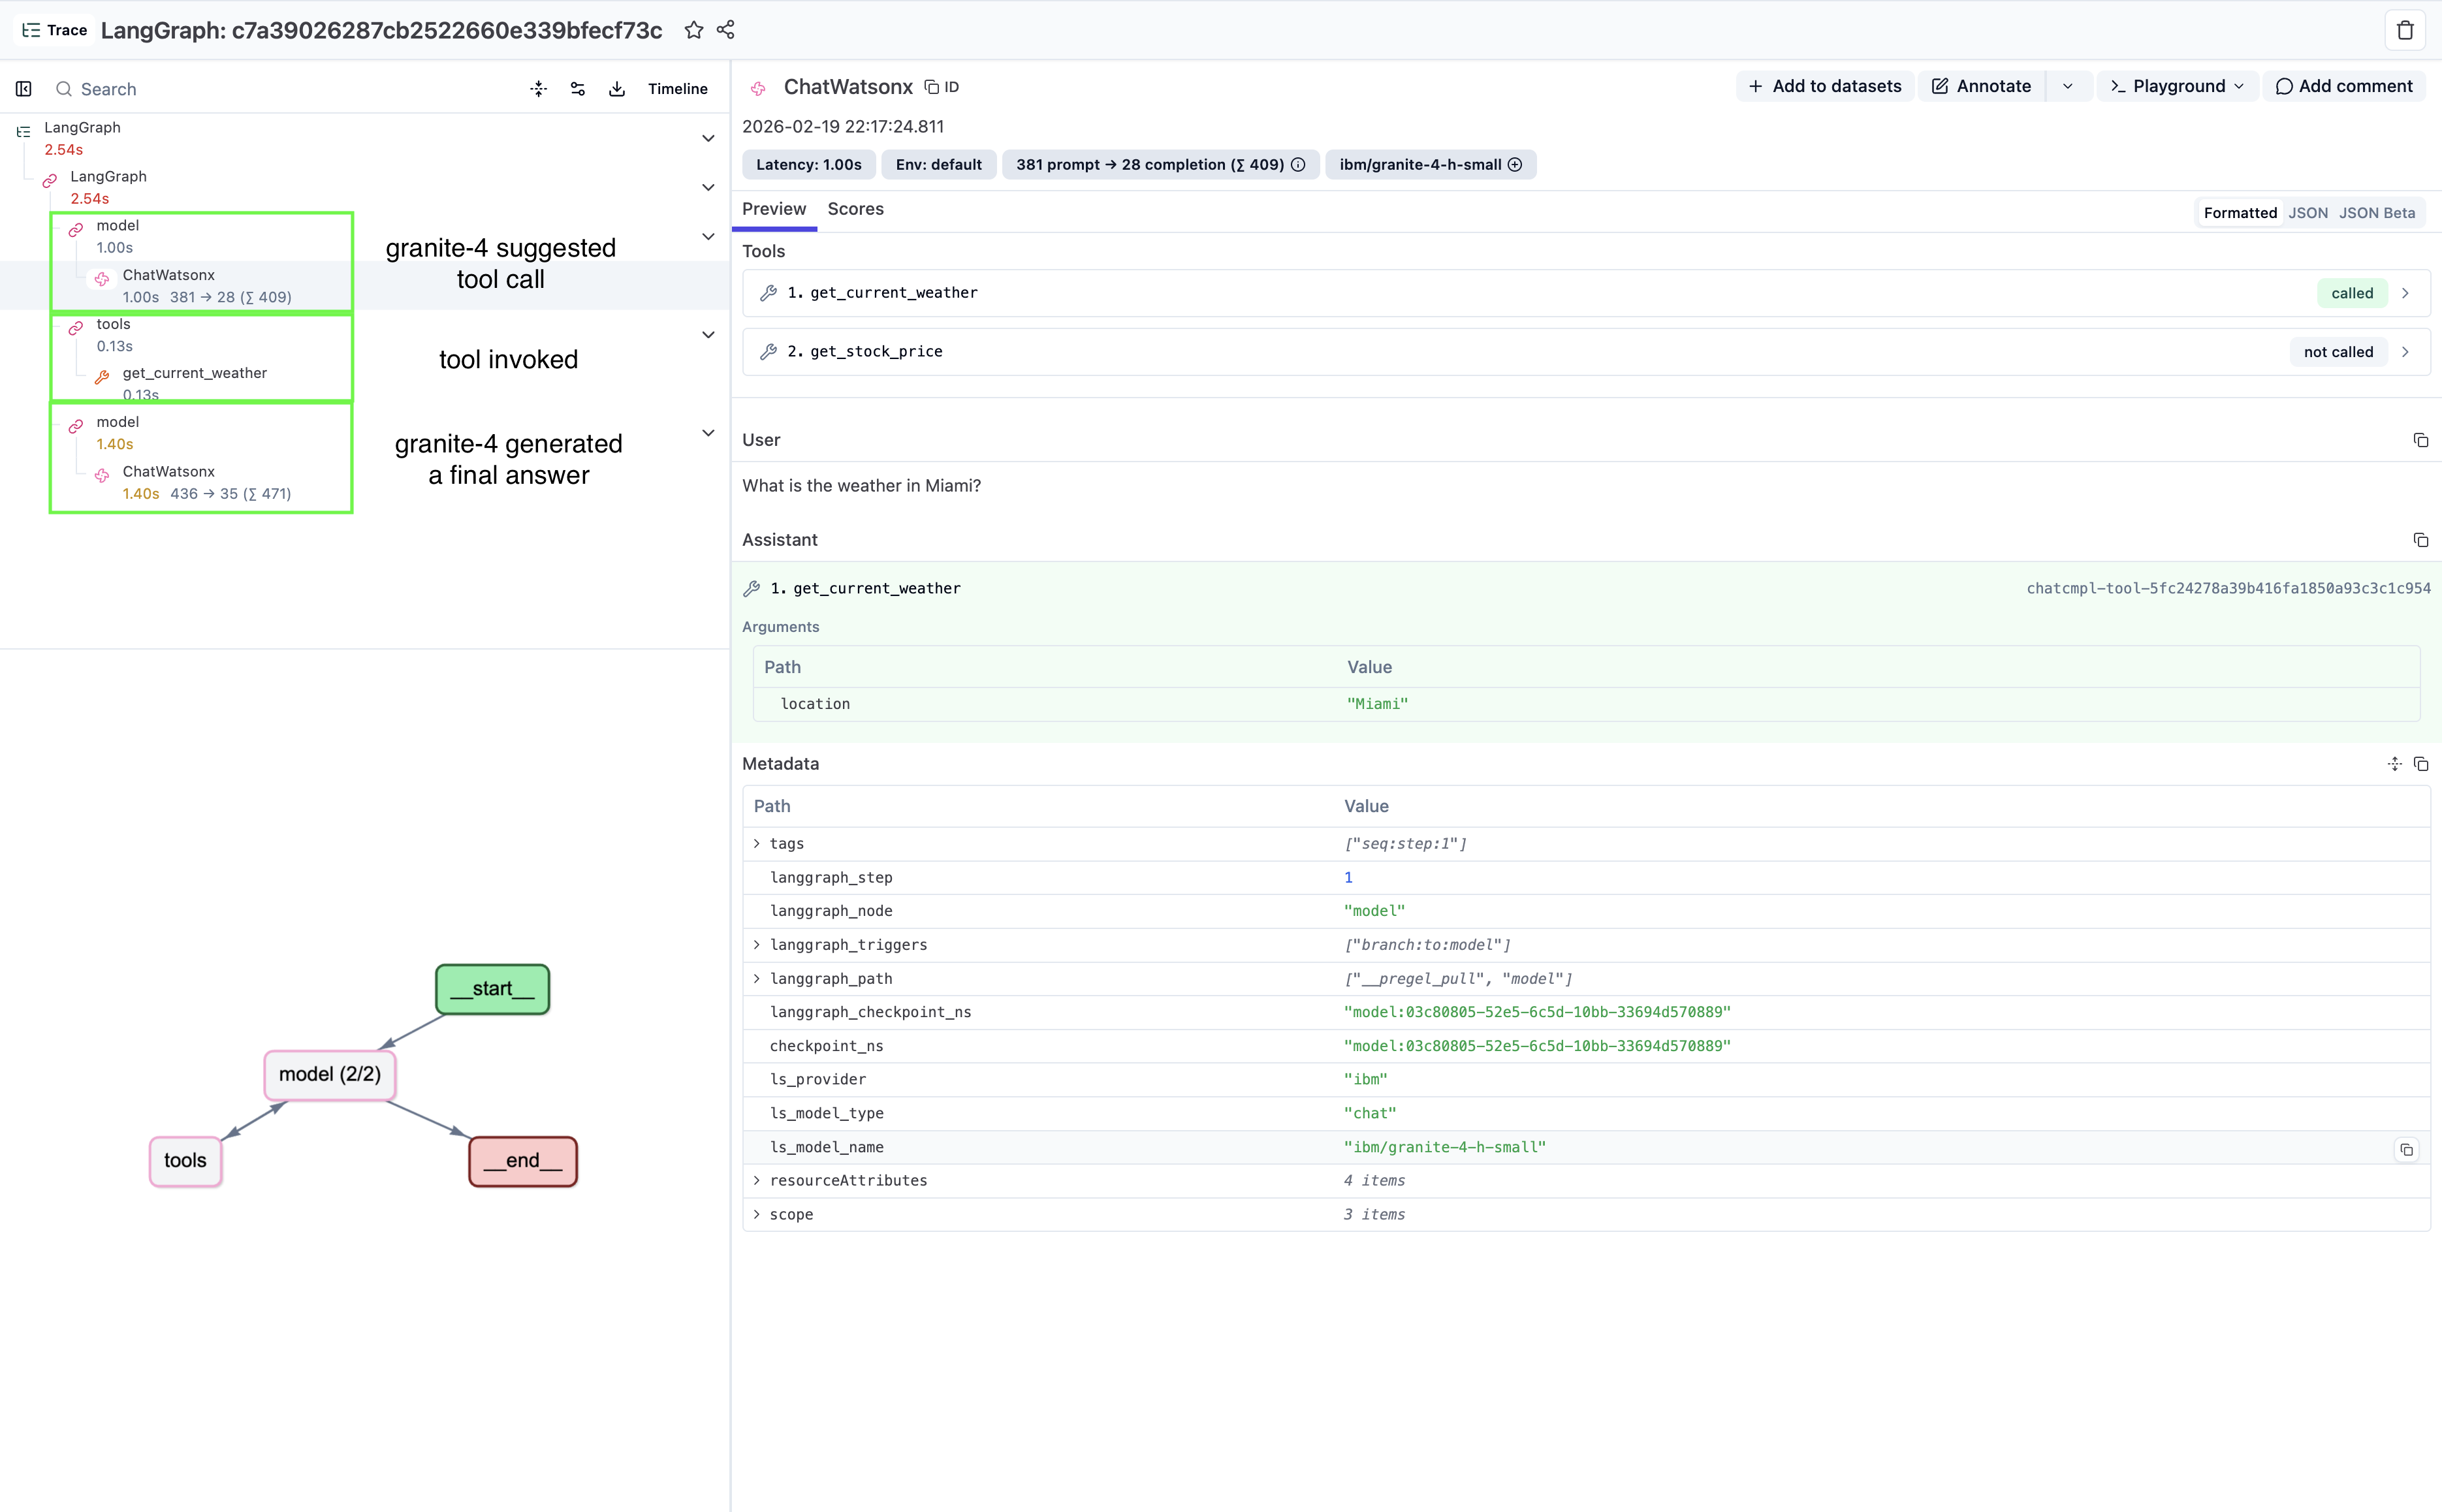

## 4. Collect and Read a Langfuse Trace

In [ ]:
def save_as_json(data, output_filename="output.json"):
    print("saving")
    with open(output_filename, 'w', encoding='utf-8') as f:
        f.write(data.json(indent=4))  

def extract(trace_id):
    langfuse = get_client()
    trace = langfuse.api.trace.get(trace_id=trace_id)
    trace_dict = trace.dict()
    
    # Exclude ChannelWrite observations. 
    # If ChannelWrite are desired, simply set "exclude_channel_write = False" bellow
    
    # Information : ChannelWrite nodes are used internally by LangGraph to 
    #               manage the flow of information and updates between different 
    #               nodes or agents within a graph
    
    exclude_channel_write = True
    
    if exclude_channel_write:
        _observation = []
        for observation in trace.observations:
            if "ChannelWrite" not in observation.name:
                _observation.append(observation)
        
        trace_dict['observations'] = [_observation[0]]
        trace = TraceWithFullDetails(
            **trace_dict
        )

    save_as_json(trace, f"./trace.json")

Obtain the **trace_id** of the last agent execution :

In [ ]:
trace_id = langfuse_handler.last_trace_id
print(f"Last trace ID: {trace_id}")

try:
    print(f"Extracting for trace {trace_id}")
    extract(trace_id)
except Exception as e:
    print(str(e))

try:
    with open('trace.json') as f:
        trace_json = json.load(f)
except FileNotFoundError as e:
    print(f"Trace was not saved locally")
    trace_url = 'https://raw.githubusercontent.com/granite-agent-cookbook/refs/heads/main/recipes/Tracing/trace.json'
    trace_json = json.loads(urllib.request.urlopen(trace_url).read().decode())

### Reading a Langfuse Trace as JSON

Here are a few tips and tricks to explore your trace data if you have extracted it as a JSON file.

#### Understanding the Trace Structure

A Langfuse trace JSON contains several key sections:

##### 1. **Top-Level Trace Information**
- `id`: Unique identifier for the trace
- `name`: Name of the traced operation (e.g., "LangGraph")
- `timestamp`: When the trace was created
- `latency`: Total execution time in seconds

##### 2. **Input and Output (Messages)**

The trace's `input` and `output` fields contain the conversation flow:

**Input** (`trace.input`):
```json
{
  "messages": [
    "What is the weather in Miami?"
  ]
}
```
This represents the initial user query.

**Output** (`trace.output`):
```json
{
  "messages": [
    {...},  // Human message
    {...},  // AI message with tool call
    {...},  // Tool response
    {...}   // Final AI response
  ]
}
```

The output contains a **list of messages** representing the complete conversation flow:

1. **Human Message** (`type: "human"`):
   - Contains the user's question
   - Has a unique `id` for reference

2. **AI Message with Tool Call** (`type: "ai"`):
   - The model's decision to use a tool
   - `tool_calls`: Array of tools the model wants to invoke
   - `response_metadata`: Contains token usage and model information

3. **Tool Message** (`type: "tool"`):
   - Contains the tool's execution result
   - `content`: The actual data returned by the tool
   - `tool_call_id`: Links back to the tool call that triggered it

     To find the output of a tool_call execution, locate the observation who's output message has a tool_call_id equal to the id value of the tool_call you are interested in.


4. **Final AI Message** (`type: "ai"`):
   - The model's final response using the tool results
   - `content`: Human-readable answer
   - `finish_reason: "stop"`: Indicates completion

##### 3. **Observations**

The `observations` array (`trace.observations`) contains detailed execution steps:

- **Types**: `GENERATION`, `SPAN`, `CHAIN`, `EVENT`
- **Key Fields**:
  - `name`: Operation name (e.g., "route_tools", "llm")
  - `input`: Data sent to this step
  - `output`: Data returned from this step
  - `metadata`: Additional context (LangGraph step info, node names, etc.)
  - `startTime` / `endTime`: Timing information
  - `parentObservationId`: Links to parent observation for hierarchy

#### Reading the Message Flow

To understand the execution flow:

1. Start with `trace.input.messages` for the initial query
2. Follow `trace.output.messages` sequentially to see:
   - User question → AI tool call → Tool execution → AI final answer
3. Cross-reference with `trace.observations` for detailed execution metadata
4. Match tool calls using `tool_call_id` to link requests and responses


In [ ]:
def extract_tool_calls(trace_data):
    """
    Extract tool calls and their corresponding results from a Langfuse trace.
    
    Tool calls are found in AI messages that have a non-empty 'tool_calls' list.
    Tool call results are matched by tool_call_id, searching first in the trace
    output messages, then falling back to the observations.
    
    Returns a list of dicts with keys: name, args, tool_call_id, result
    """
    messages = trace_data.get("output", {}).get("messages", [])
    observations = trace_data.get("observations", [])

    # Collect all tool calls from AI messages
    tool_calls = []
    for msg in messages:
        if msg.get("type") in ("ai", "assistant") and msg.get("tool_calls"):
            for tc in msg["tool_calls"]:
                tool_calls.append({
                    "name": tc["name"],
                    "args": tc["args"],
                    "tool_call_id": tc["id"],
                    "result": None,
                })

    for tc in tool_calls:
        tid = tc["tool_call_id"]

        for msg in messages:
            if msg.get("type") == "tool" and msg.get("tool_call_id") == tid:
                tc["result"] = msg.get("content")
                break

        if tc["result"] is None:
            for obs in observations:
                obs_output = obs.get("output", {}) or {}
                obs_meta = obs.get("metadata", {}) or {}
                if (obs_output.get("tool_call_id") == tid
                        or obs_meta.get("tool_call_id") == tid):
                    tc["result"] = obs_output.get("content")
                    break

    return tool_calls

In [ ]:
tool_calls = extract_tool_calls(trace_json)

for tc in tool_calls:
    print(f"Tool:    {tc['name']}")
    print(f"Args:    {tc['args']}")
    print(f"Call ID: {tc['tool_call_id']}")
    print(f"Result:  {tc['result']}")
    print()

## 5. Conclusion

In this notebook, we added observability to a granite agent using **Langfuse tracing** by:                                                                                                                                 
                                                                                                                                                                                                                                                
- **Reusing the function-calling agent** using LangChain's `create_agent`, equipped with stock price and weather tools.
- **Instrumenting the agent** with Langfuse's callback handler, which automatically captured traces from LangChain's execution hierarchy : chains, LLM generations, and tool calls, without any code changes to the agent itself.
- **Collecting and explore a trace** programmatically via the Langfuse API, examining the JSON structure to understand the full lifecycle of an agent request.

Tracing is a foundational step toward reliable agent development. With traces, you can track unexpected agent trajectories, measure latency across steps, and identify which tool calls or LLM generations need improvement.

To go further, explore the **Advanced Topics** section below, which will cover:
    
- **Experiments** — systematically evaluate agent outputs against expected results with automated scoring.
- **Manual tracing** — gain fine-grained control over trace structure when automatic instrumentation isn't sufficient.


## 6. Advanced topics

### Create a Langfuse experiment to evaluate the agent output

Experiment tracking should be a foundational practice to build into your agent workflow from day one.
[(IBM, Agent Observability and Operations)](https://www.ibm.com/downloads/documents/us-en/1443d5dd174f42e6)

Langfuse experiments are used to loop your agent through a dataset and optionally apply Evaluation Methods to the results :

1. Create dataset items with inputs and expected outputs
2. Define your task function to test
3. Write evaluators to score results
4. Run experiment to get automated scores across all test cases

| Component | Description | Example |
|-----------|-------------|---------|
| **Dataset** | Collection of test cases | defined as `local_data` in this notebook with stock price questions |
| **Dataset Item** | Single test case with input and optional expected output | `{"input": "What were...", "expected_output": "On September..."}` |
| **Task** | Application code being tested | `agent_execution_to_evaluate()` - executes your agent |
| **Evaluator** | Function that scores outputs | `accuracy_evaluator()` - checks if expected output appears in response |
| **Score** | Evaluation result (numeric/categorical/boolean) | `1.0` (correct) or `0.0` (incorrect) |
| **Experiment Run** | Execution of task on all dataset items | `langfuse_client.run_experiment()` |

In [ ]:
def agent_execution_to_evaluate(*, item, **kwargs):
    user_message = HumanMessage(item["input"])
    response = agent.invoke( {"messages": [user_message]})
    return response.get('messages')[-1].content
    
local_data = [
    {
    "input": "What were the IBM stock prices on Februray 13, 2026?", 
    "expected_output": "on february 13 2026, ibm’s stock traded between **$256.64** (low) and **$264.66** (high)."
    }
]

# Define evaluation functions
def accuracy_evaluator(*, input, output, expected_output, metadata, **kwargs):
    if not expected_output:
        return Evaluation(name="accuracy", value=0.0, comment="No expected output provided")
    
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
    scores = scorer.score(expected_output, output)
    
    rouge_l_fmeasure = scores['rougeL'].fmeasure
    
    return Evaluation(
        name="accuracy",
        value=rouge_l_fmeasure,
        comment=f"ROUGE-1: {scores['rouge1'].fmeasure:.3f} | ROUGE-L: {scores['rougeL'].fmeasure:.3f}"
    )


def length_evaluator(*, input, output, **kwargs):
    return Evaluation(name="response_length", value=len(output), comment=f"Response has {len(output)} characters")
    
result = langfuse_client.run_experiment(
    name="Stock Market Quizz",
    description="Testing basic functionality",
    data=local_data,
    task=agent_execution_to_evaluate,
    evaluators=[accuracy_evaluator, length_evaluator]
)

After running the experiment, you can view the results in the Langfuse dashboard.

In the above example our experiment tracked two key metrics:

**Accuracy**: A ROUGE-L score evaluating how closely granite response matches the expected answer, based on the longest common subsequence between the two texts.

**Response Length**: The character count of each response, helping assess verbosity.

#### Review the experiment in Langfuse UI

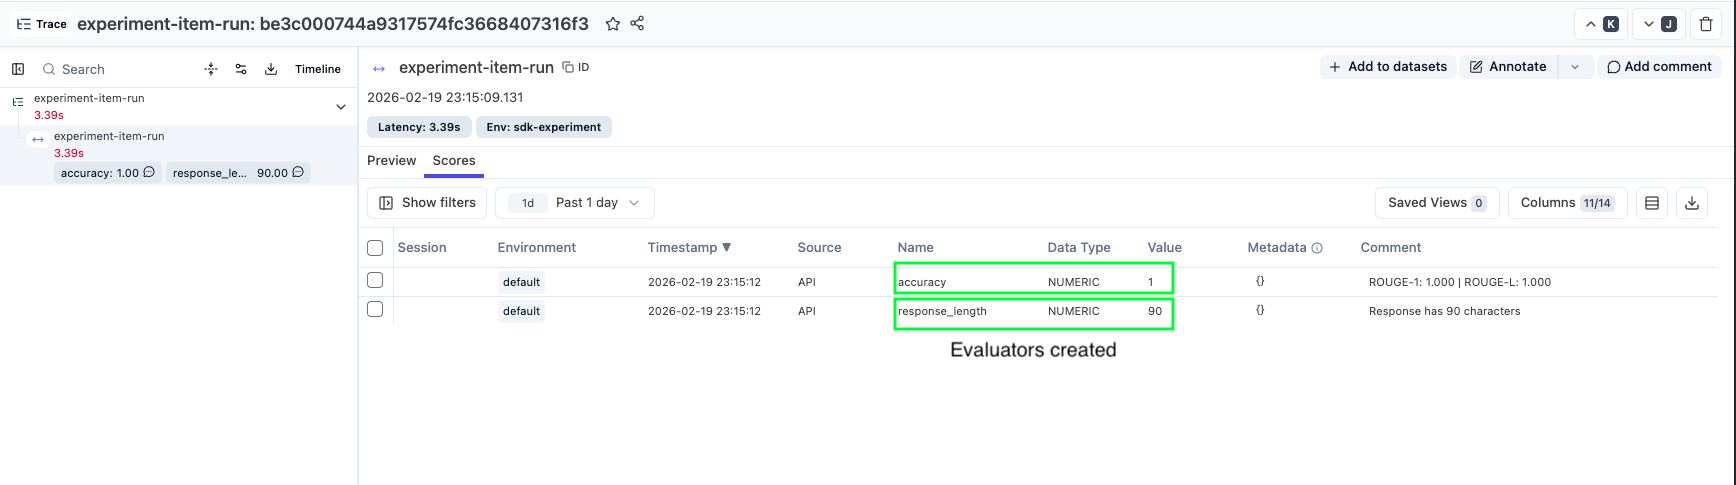

### Send a Trace to Langfuse Manually 

#### Managing Langfuse observations with a simple nested trace

In this example, we manually create a nested trace using context managers.The root observation is a chain that contains a generation and a tool call as children.

In [ ]:
with langfuse_client.start_as_current_observation(
    as_type="chain",
    name="example_agent",
    input={"query": "What's the weather in San Francisco?"}
) as root:
    
    with langfuse_client.start_as_current_observation(
        as_type="generation",
        name="llm",
        input={"messages": [{"role": "user", "content": "What's the weather in San Francisco?"}]},
        model=model
    ) as gen:
        gen.update(
            output={"content": "I'll check the weather in San Francisco."},
            usage={"input": 10, "output": 5, "total": 15}
        )
    with langfuse_client.start_as_current_observation(
        as_type="tool",
        name="weather_tool",
        input={"location": "San Francisco"}
    ) as tool:
        tool.update(output={"temp": 72, "conditions": "sunny"})

    root.update(output={"response": "It's 72°F and sunny"})

langfuse_client.flush()

print(f"Trace ID: {root.trace_id}")

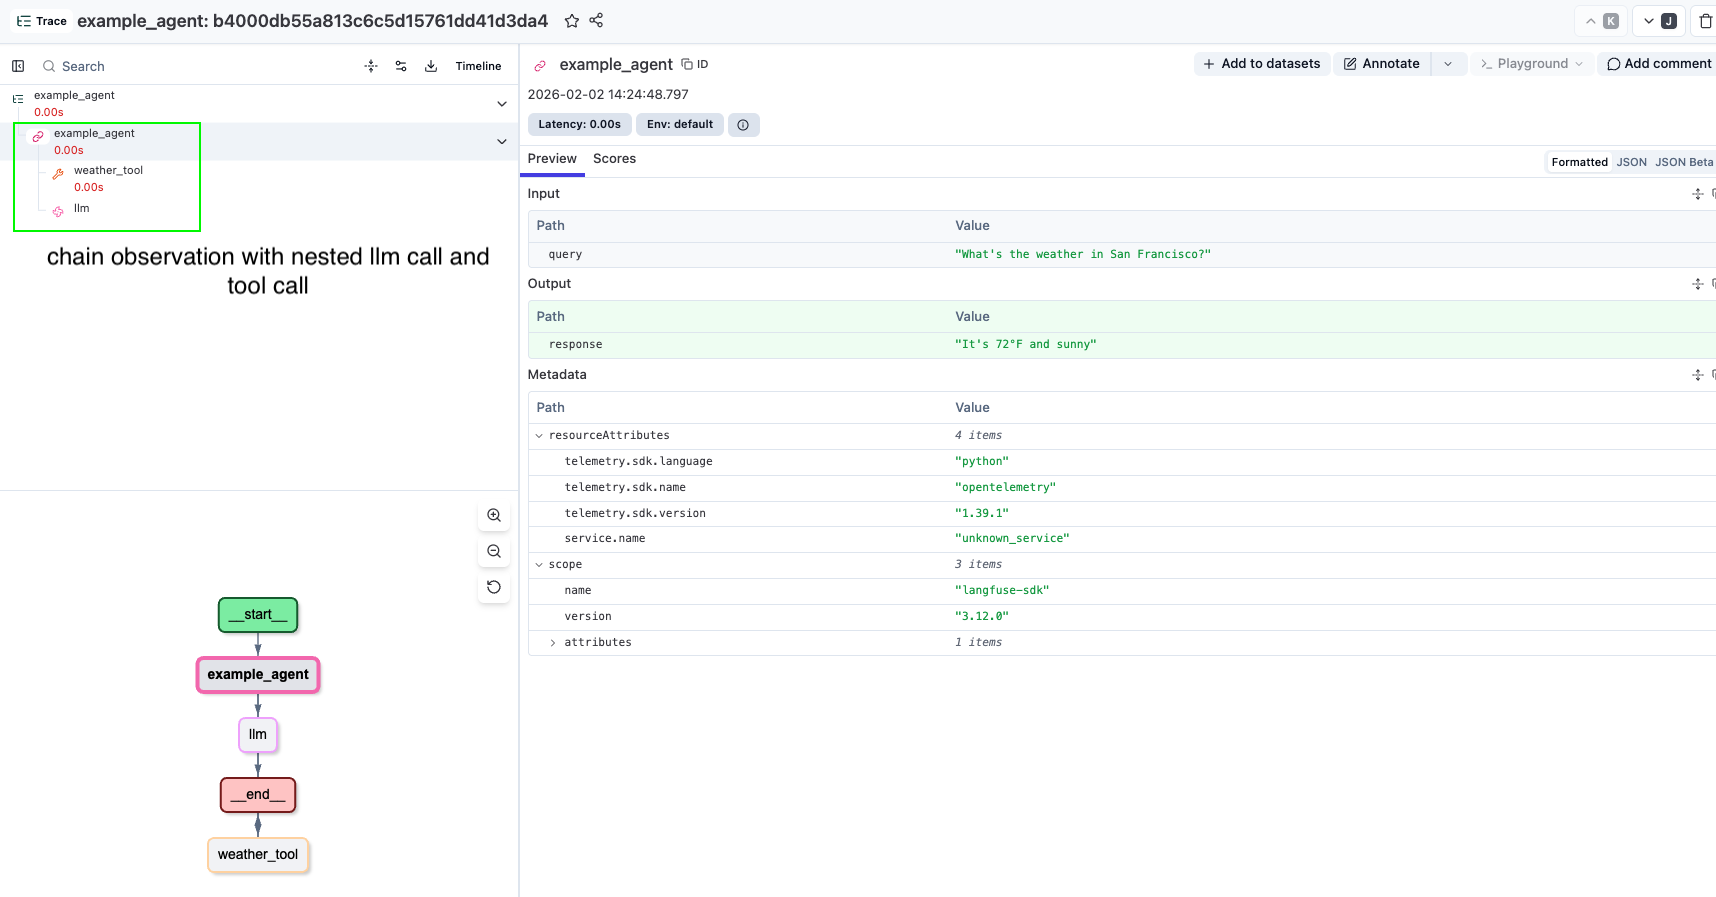

#### Managing Langfuse observations for LangGraph events

In this section we stream our function calling LangGraph agent execution and log each step : Granite calls and tool executions are tracked as nested observations within a single Langfuse trace named ```Simple_Agent_Trace```.

In [ ]:
class LangfuseObservationTracker:
    """    
    Uses langfuse_client.start_as_current_observation() to create child
    observations. Nesting is automatic through OpenTelemetry context
    propagation — any observation created within the root trace's context
    manager becomes a child of that trace.
    """

    def __init__(self, langfuse_client):
        """
        Initialize the tracker with a Langfuse client.
        
        Args:
            langfuse_client: The Langfuse client instance used to create observations
        """
        self.langfuse_client = langfuse_client

    def track_llm_call(self, name: str, input_messages: Any, output: Any, model: Optional[str] = None):
        """
        Track an LLM call as a Langfuse generation.
        
        A generation is a specialized observation type for AI model interactions.
        It captures the input prompt, output response, and model information.
        
        Args:
            name: Name of the LLM call (e.g., "ChatModel")
            input_messages: The input messages sent to the LLM
            output: The response from the LLM
            model: Optional model name (e.g., "ibm/granite-4-h-small")
        """
        print(f"  Tracking LLM call: {name}")
        
        with self.langfuse_client.start_as_current_observation(
            as_type="generation",
            name=name,
            input=input_messages,
            model=model,
        ) as generation:
            generation.update(output=output)
        return generation

    def track_tool_call(self, name: str, tool_input: Any, tool_output: Any):
        """
        Track a tool execution as a Langfuse tool observation.
        
        A tool observation captures when the agent calls an external tool/function.
        It records what tool was called, with what input, and what it returned.
        
        Args:
            name: Name of the tool (e.g., "get_current_weather")
            tool_input: The input arguments passed to the tool
            tool_output: The result returned by the tool
        """
        print(f"  Tracking tool call: {name}")
        
        with self.langfuse_client.start_as_current_observation(
            as_type="tool",
            name=name,
            input=tool_input,
        ) as tool_obs:
            tool_obs.update(output=tool_output)
        return tool_obs

In [ ]:
def test_event_generator(graph: CompiledStateGraph, user_input: str):
    """
    manual Langfuse tracing from our langgraph graph execution.
    
    Steps:
    1. Create root trace - container for all observations, represents entire agent execution
    2. Stream agent events - capture step-by-step graph node executions
    3. Log observations - LLM calls as "generation", tool calls as "tool"
    4. Flush to Langfuse - ensure all data is sent to server
    """

    user_message = HumanMessage(user_input)
    input_state = State(messages=[user_message])
    session_id = str(uuid.uuid4())

    print(f"User input: {user_input}")
    print(f"Session ID: {session_id}\n")

    print("STEP 1: Creating root trace...")

    with langfuse_client.start_as_current_observation(
        as_type="chain",
        name="Simple_Agent_Trace",
        input={"user_message": user_input},
        metadata={"session_id": session_id}
    ) as trace:
        print(f"Trace created with ID: {trace.trace_id}\n")

        tracker = LangfuseObservationTracker(langfuse_client)

        print("STEP 2: Executing agent and capturing events...\n")

        final_output = None
        llm_call_count = 0
        tool_call_count = 0

        # event is a dict with node_name as key and state update as value
        for event in graph.stream(input_state):
            for node_name, state_update in event.items():
                print(f"Node executed: {node_name}")

                if node_name == "model":
                    llm_call_count += 1
                    messages = state_update.get("messages", [])
                    if messages:
                        last_message = messages[-1]

                        input_msgs = input_state.get("messages", []) if llm_call_count == 1 else []
                        output_content = last_message.content if hasattr(last_message, "content") else str(last_message)

                        tracker.track_llm_call(
                            name=f"LLM_Call_{llm_call_count}",
                            input_messages=input_msgs,
                            output={"content": output_content},
                            model=model
                        )

                        if hasattr(last_message, "tool_calls") and last_message.tool_calls:
                            print(f"  LLM decided to call {len(last_message.tool_calls)} tool(s)")
                        else:
                            print(f"  LLM generated final response")

                elif node_name == "tools":
                    tool_call_count += 1
                    messages = state_update.get("messages", [])
                    if messages:
                        for msg in messages:
                            if hasattr(msg, "name"):
                                tool_name = msg.name
                                tool_output = msg.content if hasattr(msg, "content") else str(msg)
                                tracker.track_tool_call(
                                    name=tool_name,
                                    tool_input={"call": f"Tool call #{tool_call_count}"},
                                    tool_output={"result": tool_output}
                                )
                                print(f"  Tool '{tool_name}' executed")
                final_output = state_update

        if final_output and "messages" in final_output:
            final_message = final_output["messages"][-1]
            final_response = final_message.content if hasattr(final_message, "content") else str(final_message)
        else:
            final_response = "No response generated"

        print("\nSTEP 4: Finalizing trace...")
        trace.update(output={"final_response": final_response})

    langfuse_client.flush()
    print("Trace data sent to Langfuse\n")

    print("-" * 80)
    print("EXECUTION SUMMARY:")
    print(f"  LLM calls: {llm_call_count}")
    print(f"  Tool calls: {tool_call_count}")
    print(f"  Final response: {final_response[:100]}...")
    print(f"  Trace ID: {trace.trace_id}")
    print(f"  View in Langfuse: {os.environ.get('LANGFUSE_HOST', 'https://cloud.langfuse.com')}/trace/{trace.trace_id}")
    print("=" * 80 + "\n")

    return {
        "session_id": session_id,
        "output": final_response,
        "trace_id": trace.trace_id,
        "llm_calls": llm_call_count,
        "tool_calls": tool_call_count
    }

In [ ]:
user_input = "What is the weather in Miami?"
test_event_generator(graph=agent,user_input=user_input)

The resulting ```Simple_Agent_Trace``` trace in Langfuse shows the full agent execution as a nested hierarchy:

```Simple_Agent_Trace → LLM_Call_1 → get_current_weather → LLM_Call_2```

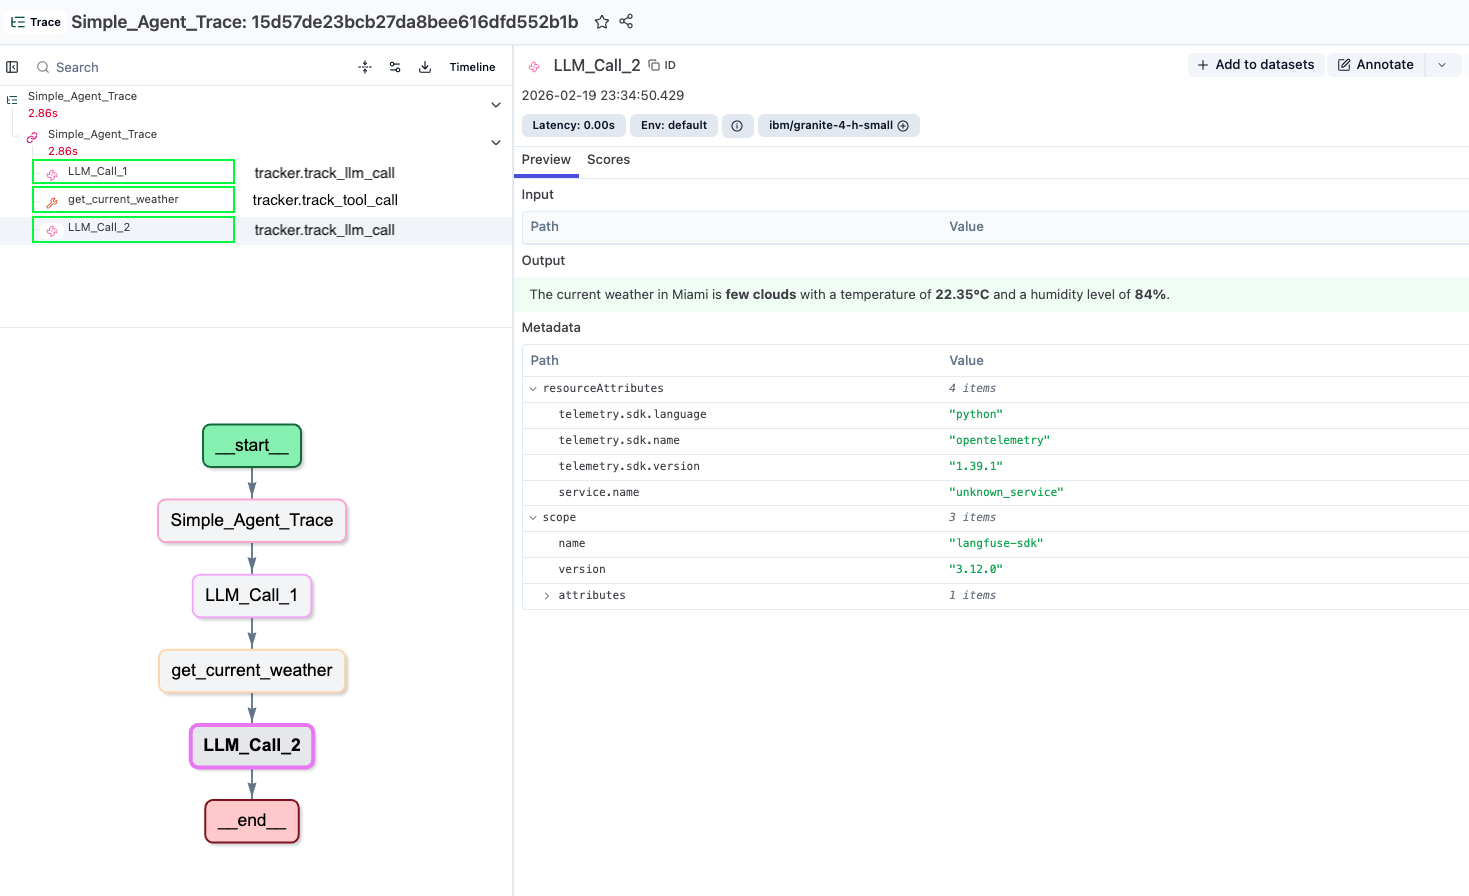